# 6. Decision Trees and Ensemble Learning
## Homework

The goal of this homework is to create a regression model for predicting housing prices (column 'median_house_value').  

In this homework we'll again use the California Housing Prices dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices) or download using wget link mentioned below:

```
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

```

In [1]:
#@ IMPORTING LIBRARIES AND DEPENDENCIES:
import re
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
#from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
#from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
#@ DOWNLOADING THE DATASET: UNCOMMENT BELOW:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

/bin/bash: wget: command not found


Use only the following columns:  
* `'latitude'`,
* `'longitude'`,
* `'housing_median_age'`,
* `'total_rooms'`,
* `'total_bedrooms'`,
* `'population'`,
* `'households'`,
* `'median_income'`,
* `'median_house_value'`,
* `'ocean_proximity'`  

In [3]:
#@ READING DATASET:
PATH = '../data/housing.csv'
features_cols = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", 
                 "households", "median_income", "median_house_value", "ocean_proximity"]
df = pd.read_csv(PATH, usecols=features_cols)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


* Fill NAs with 0.

In [4]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [5]:
df.total_bedrooms = df.total_bedrooms.fillna(0)
df.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

* Apply the log tranform to `median_house_value`.

In [6]:
df.median_house_value = np.log1p(df.median_house_value)

* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1.

In [7]:
def split_train_val_test(df, val_size, test_size, target, random_state):
    """
    Splits the dataset into 3 parts: train/validation/test with 
    (1-val_size-test_size)/val_size/test_size distribution. 
    Extracts the target variable from all datasets.
    """
    
    # Split the dataset into 2 parts: full_train/test with (train_size+val_size)/test_size distribution
    df_full_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)
    
    # Split the full_train dataset into 2 parts: train/val with train_size/val_size distribution
    df_train, df_val = train_test_split(df_full_train, test_size=val_size/(1-test_size), random_state=random_state)
    
    # Verify the lenghts of datasets
    print(len(df_train), len(df_val), len(df_test))
    
    # Reset indices of all datasets 
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    df_full_train = df_full_train.reset_index(drop=True)
    
    # Extract target variable from all datasets 
    y_train = df_train[target].values
    y_val = df_val[target].values
    y_test = df_test[target].values

    # Delete target variable from all datasets 
    del df_train[target]
    del df_val[target]
    del df_test[target]
    
    return df_full_train, df_train, df_val, df_test, y_train, y_val, y_test

In [8]:
#@ SPLITTING THE DATASET FOR TRAINING AND TEST:
df_full_train, df_train, df_val, df_test, y_train, y_val, y_test =\
            split_train_val_test(df, 0.2, 0.2, 'median_house_value', 1)

12384 4128 4128


- We will use `DictVectorizer` to turn train and validation into matrices.

In [9]:
#@ IMPLEMENTATION OF DICTVECTORIZER:
train_dict = df_train.to_dict(orient='records')
val_dict = df_val.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)
X_train = dv.transform(train_dict)
X_val = dv.transform(val_dict)

**Question 1**

Let's train a decision tree regressor to predict the `median_house_value` variable.

Train a model with `max_depth=1`.

In [10]:
#@ TRAINING THE REGRESSION MODEL:
dtreg = DecisionTreeRegressor(max_depth=1)
dtreg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [13]:
#@ INSPECTION:
print(export_text(dtreg, feature_names=list(dv.get_feature_names_out())))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



- Which feature is used for splitting the data?

**Answer 1.** The feature `ocean_proximity=INLAND` is used for splitting the data.

**Question 2**

Train a random forest model with these parameters:

- `n_estimators=10`  
- `random_state=1`  
- `n_jobs=-1` (optional-to make training faster)

In [14]:
#@ TRAINING RANDOM FOREST MODEL:
rfreg = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rfreg.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [15]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [16]:
#@ CALCULATING MEAN SQUARED ERROR:
y_pred = rfreg.predict(X_val)
rmse(y_val, y_pred).round(2)

0.25

- What's the RMSE of this model on validation?

**Answer 2.** The RMSE of this model on validation set is **0.25**

**Question 3**

Now, let's experiment with the `n_estimators` parameter.

- Try different values of this parameter from 10 to 200 with step 10.
- Set `random_state` to 1.
- Evaluate the model on the validation dataset.

In [17]:
#@ TRAINING THE RANDOM FOREST MODEL:
scores = []

for n in range(10, 201, 10):
    rfreg = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rfreg.fit(X_train, y_train)
    y_pred = rfreg.predict(X_val)    
    
    scores.append((n, rmse(y_val, y_pred)))

In [18]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])
df_scores

,n_estimators,rmse
0,10,0.245792
1,20,0.239150
2,30,0.235651
3,40,0.234542
4,50,0.233054
5,60,0.232915
6,70,0.232499
7,80,0.232567
8,90,0.232220
9,100,0.231943


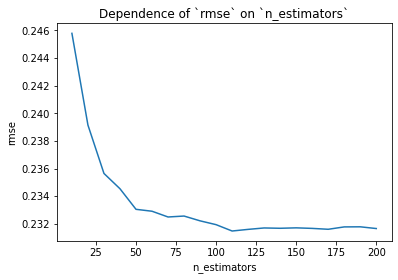

In [19]:
#@ INSPECTING THE RMSE SCORES:
plt.title('Dependence of `rmse` on `n_estimators`')
plt.plot(df_scores.n_estimators, df_scores.rmse)
plt.xlabel('n_estimators')
plt.ylabel('rmse');

- After which value of `n_estimators` does RMSE stop improving?

**Answer 3.** After `n_estimators = 110` RMSE stops improving (answer = 70).

**Question 4**

Let's select the best `max_depth`:

- Try different values of `max_depth`: [10, 15, 20, 25].
- For each of these values, try different values of n_estimators from 10 till 200 (with step 10).
- Fix the random seed: `random_state=1`.

In [20]:
#@ TRAINING THE MODEL WITH DEPTH:
scores = []

for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rfreg = RandomForestRegressor(n_estimators=n,
                                      max_depth=d,
                                      random_state=1, 
                                      n_jobs=-1)
        rfreg.fit(X_train, y_train)
        y_pred = rfreg.predict(X_val)    
        
        scores.append((d, n, rmse(y_val, y_pred)))


KeyboardInterrupt



In [ ]:
columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

In [ ]:
df_scores

In [ ]:
plt.title('Dependence of `rmse` on `n_estimators` with dofferent `max_depth`')
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse,
             label=f'max_depth = {d}')

plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('rmse');

- What's the best `max_depth`:

**Answer 4.** The best `max_depth` is **25**.

**Question 5**

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorith, it finds the best split. When doint it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the imporatant features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field.

For this homework question, we'll find the most important feature:

Train the model with these parametes:
- `n_estimators=10`,
- `max_depth=20`,
- `random_state=1`,
- `n_jobs=-1` (optional)

Get the feature importance information from this model

In [ ]:
#@ TRAINING THE RANDOM FOREST MODEL:
rfreg = RandomForestRegressor(n_estimators=10, 
                              max_depth=20,
                              random_state=1,
                              n_jobs=-1)
rfreg.fit(X_train, y_train)

In [ ]:
features = dv.get_feature_names_out()
feature_importances = rfreg.feature_importances_

In [ ]:
columns = ['feature', 'importance']
df_fi = pd.DataFrame(zip(features, feature_importances), columns=columns)

df_fi.sort_values('importance', ascending=False)

In [ ]:
# using pd.Series
fi = pd.Series(feature_importances, index=features)
fi.sort_values(ascending=False)

- What's the most important feature?

**Answer 5.** The most important feature is **median_income**.

**Question 6**

Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

- Install XGBoost.
- Create DMatrix for train and validation
- Create a watchlist
- Train a model with these parameters for 100 rounds:

```
xgb_params = {  
    'eta': 0.3,  
    'max_depth': 6,  
    'min_child_weight': 1,  

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
```



In [ ]:
features = dv.get_feature_names_out()

In [ ]:
# Create DMatrix for train and validation
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [ ]:
# Create a watchlist
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [ ]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [ ]:
# del
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, 
                  num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

In [ ]:
#del
scores[f'eta={xgb_params['eta']}'] = parse_xgb_output(output)
key

- Now, change eta first to 0.1 and then to 0.01.

In [ ]:
etas = [0.3, 0.1, 0.01]
scores = {}

for eta in etas:
    %%capture output

    xgb_params = {
    'eta': eta, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
    }

    model = xgb.train(xgb_params, dtrain, 
                  num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)
    
    scores[f'eta={xgb_params['eta']}'] = parse_xgb_output(output)


In [ ]:
scores

In [ ]:
plt.title('Dependence of `rmse` on `n_estimators` with dofferent `eta`')

for eta, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_rmse, label=eta)

plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('rmse');

- Which eta leads to the best RMSE score on the validation dataset?

**Answer 6.** `eta = 0.3` leads to the best RMSE score on the validation dataset.